In [1]:
from ola_models import * 
from ola_RNN import * 

import os, time, copy, math, re, json, pickle, random
import numpy as np
import pandas as pd

import torch, torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
%matplotlib inline 
import seaborn as sns

from functools import partial 

cuda_available = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda_available else "cpu")
print(f'''using device {device}''')

path = !pwd
path = path[0]
print(path)

using device cuda:0
/home/r2/Documents/RNNexp


In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
bs  = 30
sql = 1000
lr  = 0.0005 

sched = combine_scheds([0.15, 0.25, 0.2, 0.4], [sched_cos(0.0005, 0.0008), sched_cos(0.0008, 0.0005),sched_lin(0.0005,0.0005),sched_cos(0.0005,0.00005)]) 
data          = pp_trumpdata(path+"/data/trump/", [0.9,0.95], bs)
data.train_dl = TweetDataLoader(data,data.train.tweets,bs,sql,shuffle=True)
data.valid_dl = TweetDataLoader(data,data.valid.tweets,bs,30,shuffle=False)

model  = cuda(RNN(len(data.decoder), 150, len(data.decoder)))
# opt    = optim.RMSprop(model.parameters(), lr, weight_decay=0.0005, momentum=0.9)
opt    = optim.RMSprop(model.parameters(), lr, momentum=0.9)
learn  = Learner(model,  nn.NLLLoss(), opt , data, lr=lr)

model2  = cuda(GRU(len(data.decoder), 150))
# opt2    = optim.RMSprop(model2.parameters(), lr, weight_decay=0.0005, momentum=0.9)
opt2    = optim.RMSprop(model2.parameters(), lr, momentum=0.9)
learn2  = Learner(model2,  nn.NLLLoss(), opt2 , data, lr=lr)

In [4]:
class HookCallback(Callback):
    _order = 15
    def append_grad(self,grad):
        self.learn.stats.grads_mean.append(grad.abs().mean().item())
        self.learn.stats.grads_max.append(grad.abs().max().item())
        self.learn.stats.grads_max.append(grad.abs().min().item())        
        
    def begin_fit(self,learn):
        super().begin_fit(learn)
        learn.stats.grads_mean = []         
        learn.stats.grads_max  = []  
        learn.stats.grads_min  = []          
        for p in learn.model.parameters():
            p.register_hook(self.append_grad)
        return True

    def after_loss(self,loss):
        return True
    
    def after_step(self):
        return True

In [34]:
def get_grads(learn):
    layers = 0
    for p in learn.model.parameters():
        layers+=1
    mean_grad = []
    max_grad  = []
    for i in range(0,len(learn.stats.grads_mean),layers):
        means = np.array(learn.stats.grads_mean[i:i+layers])
        maxs  = np.array(learn.stats.grads_max[i:i+layers])
        if means.shape[0] != layers:return np.hstack(mean_grad), np.hstack(max_grad)
        mean_grad.append(means.reshape(layers,1))
        max_grad.append(maxs.reshape(layers,1))        
    return np.hstack(mean_grad), np.hstack(max_grad)

def plot_grad_means(grad_means, savedir=None):
    plt.figure(figsize=(15,10))
    # figure(figsize=(10,10))
    x = [i for i in range(grad_means.shape[1])]
    for layer in range(grad_means.shape[0]):    
        plt.plot(x,grad_means[layer,:],label=str(layer+1))
    plt.legend()
    plt.show()
    if savedir is not None:
        plt.savefig(savedir)
    
def plot_stats(stats):
    plot_list(stats.train_loss[100::], 'train_loss')
    plot_list(stats.train_mva_loss[100::], 'moving_average_train_loss')
    plot_list(stats.valid_loss, 'valid loss')
    plot_list(stats.valid_accu, 'valid accuracy')    

In [6]:
cbs = CallbackHandler([CounterCallback(1000),StatsCallback(),HookCallback()])

In [7]:
fit_rnn(1,learn,cbs)

learn.n_iters shouldn't be 0
getting validation
finished: 0.05000000000000004%
getting validation
finished: 0.10000000000000007%
getting validation
finished: 0.1500000000000001%
getting validation
finished: 0.20000000000000015%
getting validation
finished: 0.25000000000000017%
getting validation
finished: 0.3000000000000002%
getting validation
finished: 0.35000000000000026%
getting validation
finished: 0.4000000000000003%
getting validation
finished: 0.45000000000000034%
getting validation
finished: 0.5000000000000003%


In [8]:
fit_rnn(1,learn2,cbs)

learn.n_iters shouldn't be 0
getting validation
finished: 0.05000000000000004%
getting validation
finished: 0.10000000000000007%
getting validation
finished: 0.1500000000000001%
getting validation
finished: 0.20000000000000015%
getting validation
finished: 0.25000000000000017%
getting validation
finished: 0.3000000000000002%
getting validation
finished: 0.35000000000000026%
getting validation
finished: 0.4000000000000003%
getting validation
finished: 0.45000000000000034%
getting validation
finished: 0.5000000000000003%


In [9]:
mean_grad, max_grad  = get_grads(learn)

In [10]:
mean_grad2, max_grad2  = get_grads(learn2)

In [46]:
max_grad[1,5]

0.0

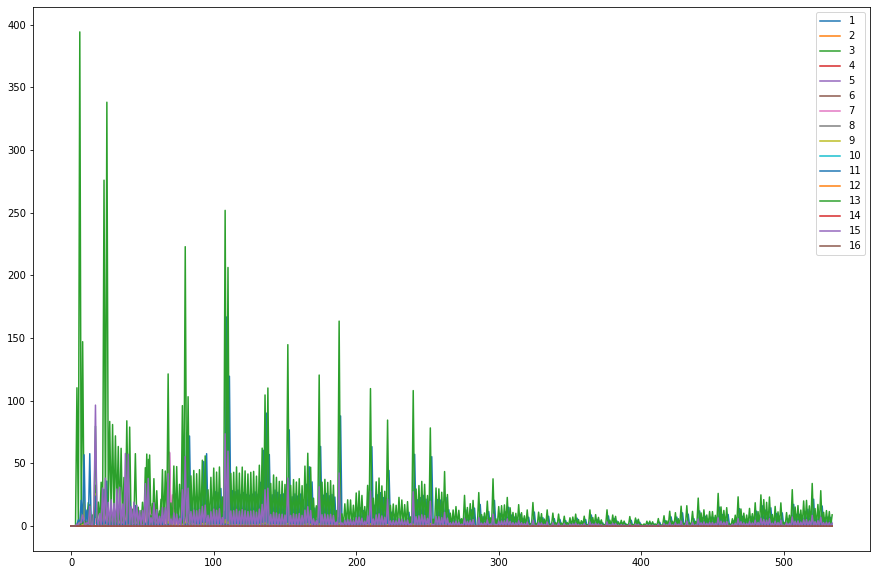

<Figure size 432x288 with 0 Axes>

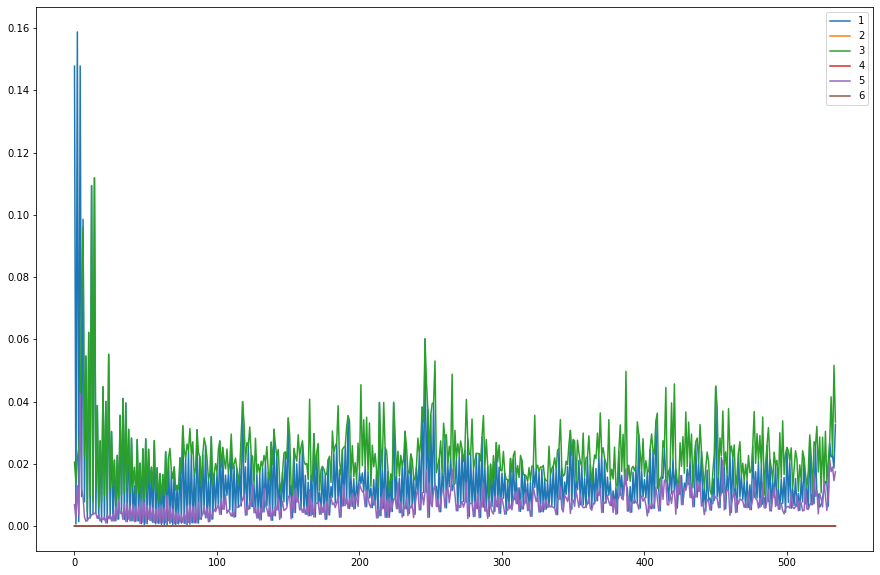

<Figure size 432x288 with 0 Axes>

In [48]:
plot_grad_means(max_grad, './exps/3/maxgradRNNwithmomentum09')
plot_grad_means(max_grad2, './exps/3/maxgradGRUwithmomentum09')

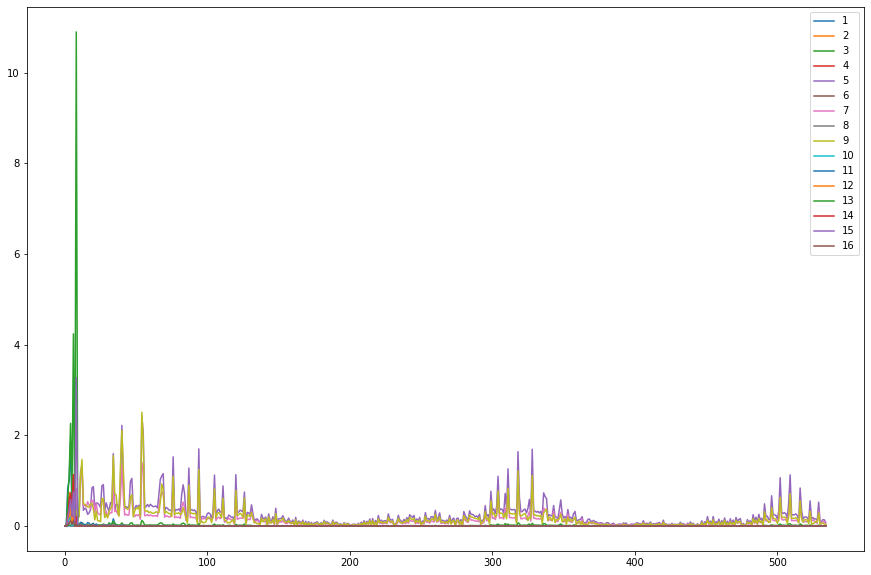

<Figure size 432x288 with 0 Axes>

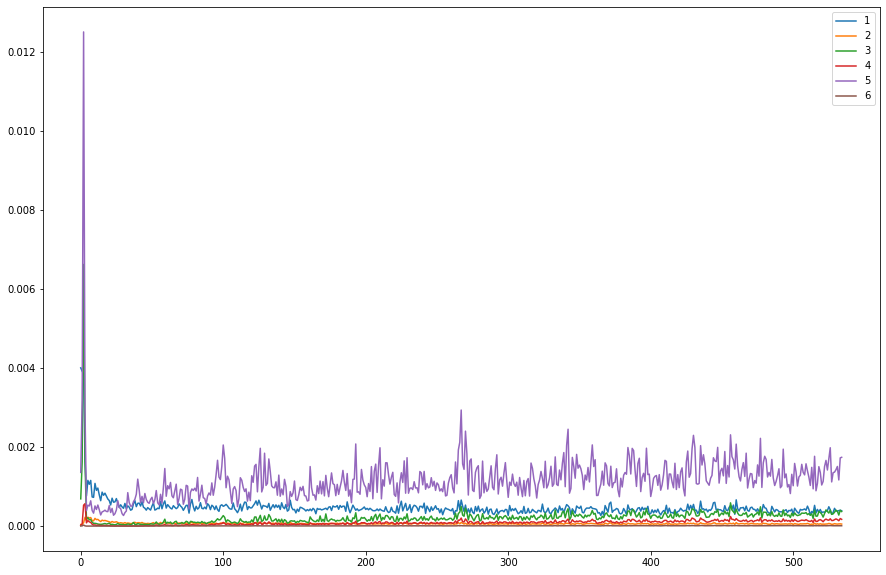

<Figure size 432x288 with 0 Axes>

In [36]:
plot_grad_means(mean_grad, './exps/3/meangradRNNwithmomentum09')
plot_grad_means(mean_grad2, './exps/3/meangradGRUwithmomentum09')

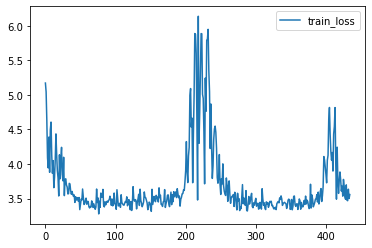

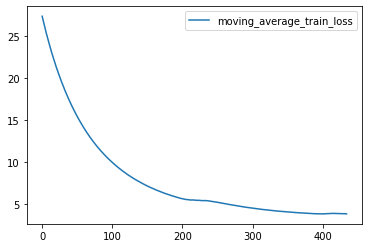

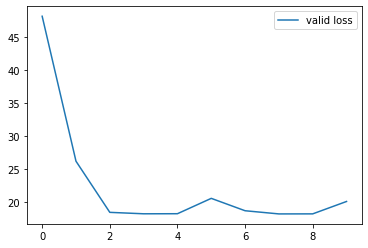

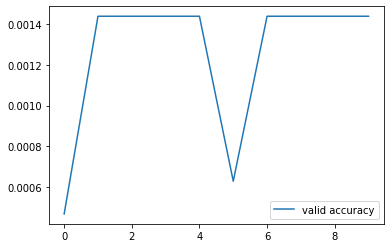

In [37]:
plot_stats(learn.stats)

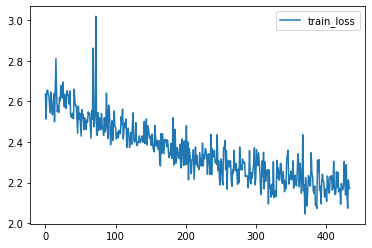

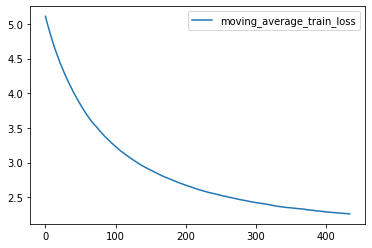

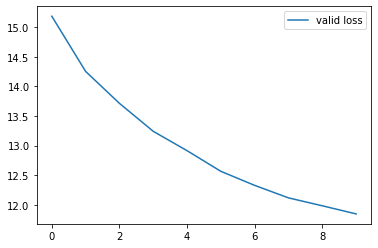

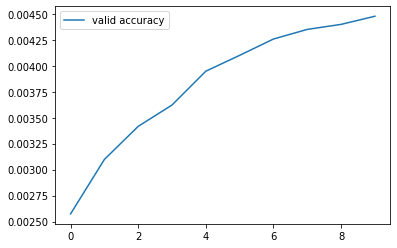

In [38]:
plot_stats(learn2.stats)

In [ ]:
generate_seq(learn.model,data,300)

In [ ]:
generate_seq(learn2.model,data,300)